# **Capstone Project**

**Project Description :**

In this capstone project, the goal is to build a classifier that can classify the tickets by analysing text.

**Business Domain Value:**

In the support process, incoming incidents are analyzed and assessed by organization’s support teams to fulfill the request. In many organizations, better allocation and effective usage of the valuable support resources will directly result in substantial cost savings. Guided by powerful AI techniques that can classify incidents to right functional groups can help organizations to reduce the resolving time of the issue and can focus on more productive tasks.

**Mount the drive to access the content in the drive**

In [1]:
#Mount the Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing all the necessary libraries**

In [2]:
#Importing Necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

%tensorflow_version 2.x
import tensorflow as tf

import string
import nltk
import re
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet') 
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem.wordnet import WordNetLemmatizer



#Importing Sklearn function for splitting dataset for training and testing
from sklearn.model_selection  import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding,Bidirectional,Dense,Flatten,LSTM,GlobalMaxPooling1D,Dropout

from sklearn.manifold import TSNE


# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers
#from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import resample

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using TensorFlow backend.


Exploratory Data analysis

In [0]:
#Load Dataset from drive
data = pd.read_excel("/content/drive/My Drive/Capstone project/input_data.xlsx")

In [14]:
#Have a look at first five rows in dataset
data.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


Understanding the structure of data

In [15]:
#number of rows and columns
rows , columns = data.shape
print("Number of Rows in Given Dataset:", rows)
print("Number of Columns in Given Dataset:" ,columns)

Number of Rows in Given Dataset: 8500
Number of Columns in Given Dataset: 4


In [16]:
#Datatypes of each attribute
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


Missing values in data

In [17]:
data.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

In [18]:
target_class  = data['Assignment group'].unique() 

print("The Number of Samples in the dataset: ", len(data)) 
for i in target_class :
  print('Group',i , ':', round(data['Assignment group'].value_counts()[i] /len(data) * 100, 2), '% of the dataset') 

The Number of Samples in the dataset:  8500
Group GRP_0 : 46.78 % of the dataset
Group GRP_1 : 0.36 % of the dataset
Group GRP_3 : 2.35 % of the dataset
Group GRP_4 : 1.18 % of the dataset
Group GRP_5 : 1.52 % of the dataset
Group GRP_6 : 2.16 % of the dataset
Group GRP_7 : 0.8 % of the dataset
Group GRP_8 : 7.78 % of the dataset
Group GRP_9 : 2.96 % of the dataset
Group GRP_10 : 1.65 % of the dataset
Group GRP_11 : 0.35 % of the dataset
Group GRP_12 : 3.02 % of the dataset
Group GRP_13 : 1.71 % of the dataset
Group GRP_14 : 1.39 % of the dataset
Group GRP_15 : 0.46 % of the dataset
Group GRP_16 : 1.0 % of the dataset
Group GRP_17 : 0.95 % of the dataset
Group GRP_18 : 1.04 % of the dataset
Group GRP_19 : 2.53 % of the dataset
Group GRP_2 : 2.84 % of the dataset
Group GRP_20 : 0.42 % of the dataset
Group GRP_21 : 0.34 % of the dataset
Group GRP_22 : 0.36 % of the dataset
Group GRP_23 : 0.29 % of the dataset
Group GRP_24 : 3.4 % of the dataset
Group GRP_25 : 1.36 % of the dataset
Group 

**Observations:**

Based on the above observations we can clearly see that data is biased towards Group 0 class with 46.78% this leading to class imbalance problem now let's deal this using sampling technqiues.

In [0]:
# Separate majority and minority classes
df_majority = data.loc[data['Assignment group'] == 'GRP_0']
df_minority = data.loc[data['Assignment group'] != 'GRP_0']
 
# Upsample minority class
df_majority_downsampled  = resample(df_majority, 
                                 replace=False,     # sample with replacement
                                 n_samples=600,    # to match majority class
                                 random_state=420) # reproducible results
 
# Combine majority class with upsampled minority class
#df_upsampled = pd.concat([df_majority, df_minority_upsampled])
data = pd.concat([df_majority_downsampled , df_minority])

In [0]:
#oversample minority

max_size = data['Assignment group'].value_counts().max()

lst = [data]
for class_index, group in data.groupby('Assignment group'):
    lst.append(group.sample(max_size-len(group), replace=True))
data = pd.concat(lst)

In [22]:
target_class  = data['Assignment group'].unique() 

print("The Number of Samples in the dataset: ", len(data)) 
for i in target_class :
  print('Group',i , ':', round(data['Assignment group'].value_counts()[i] /len(data) * 100, 2), '% of the dataset') 

The Number of Samples in the dataset:  48914
Group GRP_0 : 1.35 % of the dataset
Group GRP_1 : 1.35 % of the dataset
Group GRP_3 : 1.35 % of the dataset
Group GRP_4 : 1.35 % of the dataset
Group GRP_5 : 1.35 % of the dataset
Group GRP_6 : 1.35 % of the dataset
Group GRP_7 : 1.35 % of the dataset
Group GRP_8 : 1.35 % of the dataset
Group GRP_9 : 1.35 % of the dataset
Group GRP_10 : 1.35 % of the dataset
Group GRP_11 : 1.35 % of the dataset
Group GRP_12 : 1.35 % of the dataset
Group GRP_13 : 1.35 % of the dataset
Group GRP_14 : 1.35 % of the dataset
Group GRP_15 : 1.35 % of the dataset
Group GRP_16 : 1.35 % of the dataset
Group GRP_17 : 1.35 % of the dataset
Group GRP_18 : 1.35 % of the dataset
Group GRP_19 : 1.35 % of the dataset
Group GRP_2 : 1.35 % of the dataset
Group GRP_20 : 1.35 % of the dataset
Group GRP_21 : 1.35 % of the dataset
Group GRP_22 : 1.35 % of the dataset
Group GRP_23 : 1.35 % of the dataset
Group GRP_24 : 1.35 % of the dataset
Group GRP_25 : 1.35 % of the dataset
Gro

From the above we can see there are null values in 'Short description' and 'Description' columns,now let's deal with them.

In [23]:
# Explore the null values in the dataset

data[data.isna().any(axis=1)]

,Short description,Description,Caller,Assignment group
4395,i am locked out of skype,NaN,viyglzfo ajtfzpkb,GRP_0
3906,NaN,-user unable tologin to vpn.\r\n-connected to...,awpcmsey ctdiuqwe,GRP_0
3910,NaN,-user unable tologin to vpn.\r\n-connected to...,rhwsmefo tvphyura,GRP_0
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34
2604,NaN,\r\n\r\nreceived from: ohdrnswl.rezuibdt@gmail...,ohdrnswl rezuibdt,GRP_34


Since from the above we can observe that the values are missing either of the columns i.e Short description and Description and if we remove them we might loose crucial information so let's replace them with stop word for now,after that it will get replaced while working with textcleaning.

In [0]:
# filling NAN's with the since we can see 
data.fillna("the",inplace=True)

In [25]:
#Now let's explore if we have any null after replacing
data.isnull().sum()

Short description    0
Description          0
Caller               0
Assignment group     0
dtype: int64

In [0]:
#let's define stop_words
stop_words = set(stopwords.words("english"))

**Let's Plot the word cloud**


In [0]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stop_words,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

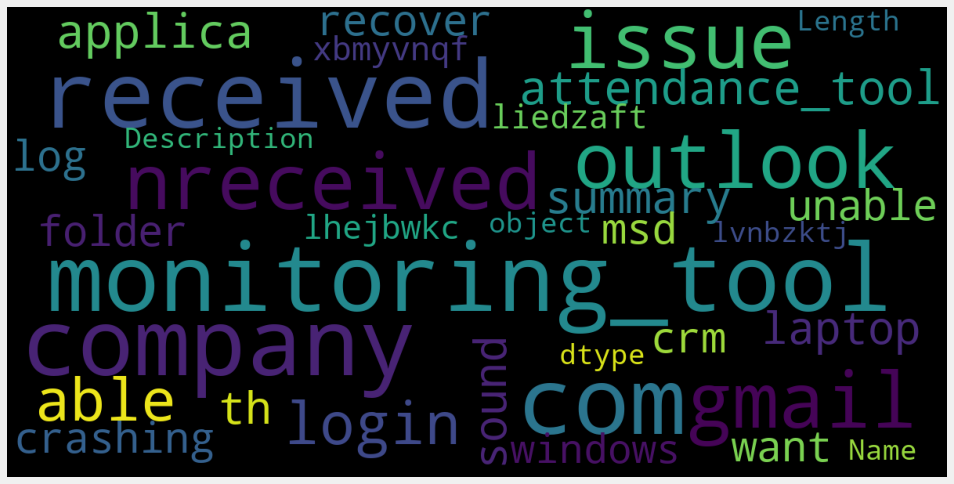

In [28]:
show_wordcloud(data.Description)

In [0]:
#Now let's hold this data in a temporary dataframe while we will work on the preprocessing
df = data

In [0]:
#Lets categories the Assignment group into unqire category and distribute the bins of words
df['target'] = df['Assignment group'].astype('category').cat.codes

df['num_words'] = df.Description.apply(lambda x : len(x.split()))
df['bins']=pd.cut(df.num_words, bins=[0,100,300,500,1000, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>1000'])

In [31]:
word_distribution = df.groupby('bins').size().reset_index().rename(columns={0:'counts'})
word_distribution.head()

,bins,counts
0,0-100,45968
1,100-300,2495
2,300-500,99
3,500-800,253
4,>1000,98


Text(0.5, 1.0, 'Word distribution per bin')

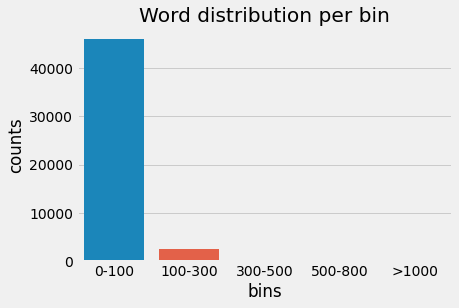

In [32]:
#Let visualize the words count as per the bins(including group)
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

In [33]:
df.head()

,Short description,Description,Caller,Assignment group,target,num_words,bins
6096,not able to login attendance_tool,i am not able to login attendance_tool applica...,cgvhxjay znyuopqk,GRP_0,0,13,0-100
3334,sound issue : 7350,summary:issue with the sound of the laptop .th...,kexcsbgw lzabjxwf,GRP_0,0,11,0-100
5962,outlook crashing : msd crm outlook issue,outlook crashing : msd crm outlook issue,wzbqmhdf gxsiadqw,GRP_0,0,7,0-100
187,to recover folder that by mistake copied to x:...,i want recover folder\r\n,pbtauqyx civyxdkl,GRP_0,0,4,0-100
7778,unable to log in to windows,unable to log in to windows,bfmlysrk olbthfqr,GRP_0,0,6,0-100


In [0]:
#Defined the preprocess text method to clean the text
def preprocess_text(sentence):
    #Convert to lowercase
    text = str(sentence).lower()

    #removing the text received from email address since this is doesn't help in model learing
    text=re.sub('received from:.\S+@\S+','',text)
    
    #remove numbers    
    text=re.sub(r'\d+', '', text)

    #Remove punctuations    
    text=text.translate(text.maketrans('', '', string.punctuation)) 
    
    #remove spaces
    text = text.strip()

    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    
    #word tokenize
    text= word_tokenize(text)
    
    #remove stop words from the text
    text=[w for w in text if not w in stop_words]
    
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word,'v') for word in text] 
    #text = " ".join(text)    
    return text


In [35]:
#let's see the data before cleaning
df.head()

,Short description,Description,Caller,Assignment group,target,num_words,bins
6096,not able to login attendance_tool,i am not able to login attendance_tool applica...,cgvhxjay znyuopqk,GRP_0,0,13,0-100
3334,sound issue : 7350,summary:issue with the sound of the laptop .th...,kexcsbgw lzabjxwf,GRP_0,0,11,0-100
5962,outlook crashing : msd crm outlook issue,outlook crashing : msd crm outlook issue,wzbqmhdf gxsiadqw,GRP_0,0,7,0-100
187,to recover folder that by mistake copied to x:...,i want recover folder\r\n,pbtauqyx civyxdkl,GRP_0,0,4,0-100
7778,unable to log in to windows,unable to log in to windows,bfmlysrk olbthfqr,GRP_0,0,6,0-100


Preprocess text on description and sub description column

In [0]:
df["Description"]=df["Description"].apply(preprocess_text)

In [37]:
df.head()

,Short description,Description,Caller,Assignment group,target,num_words,bins
6096,not able to login attendance_tool,"[able, login, attendancetool, application, use...",cgvhxjay znyuopqk,GRP_0,0,13,0-100
3334,sound issue : 7350,"[summaryissue, sound, laptop, theres, sound]",kexcsbgw lzabjxwf,GRP_0,0,11,0-100
5962,outlook crashing : msd crm outlook issue,"[outlook, crash, msd, crm, outlook, issue]",wzbqmhdf gxsiadqw,GRP_0,0,7,0-100
187,to recover folder that by mistake copied to x:...,"[want, recover, folder]",pbtauqyx civyxdkl,GRP_0,0,4,0-100
7778,unable to log in to windows,"[unable, log, windows]",bfmlysrk olbthfqr,GRP_0,0,6,0-100


In [0]:
df["Short description"]=df["Short description"].apply(preprocess_text)

In [39]:
df.tail()

,Short description,Description,Caller,Assignment group,target,num_words,bins
6109,"[job, job, fail, jobscheduler]","[job, job, fail, jobscheduler]",bpctwhsn kzqsbmtp,GRP_9,73,11,0-100
262,"[reportingtool, erp, hana, error]","[hi, everytime, want, set, filter, reportingto...",lhejbwkc xbmyvnqf,GRP_9,73,24,0-100
940,"[job, job, fail, jobscheduler]","[job, job, fail, jobscheduler]",bpctwhsn kzqsbmtp,GRP_9,73,11,0-100
8293,"[abended, job, jobscheduler, job]","[abended, job, jobscheduler, job]",ZkBogxib QsEJzdZO,GRP_9,73,11,0-100
6904,"[erp, limit]","[attempt, view, sales, data, erp, row, go, bey...",liedzaft lvnbzktj,GRP_9,73,52,0-100


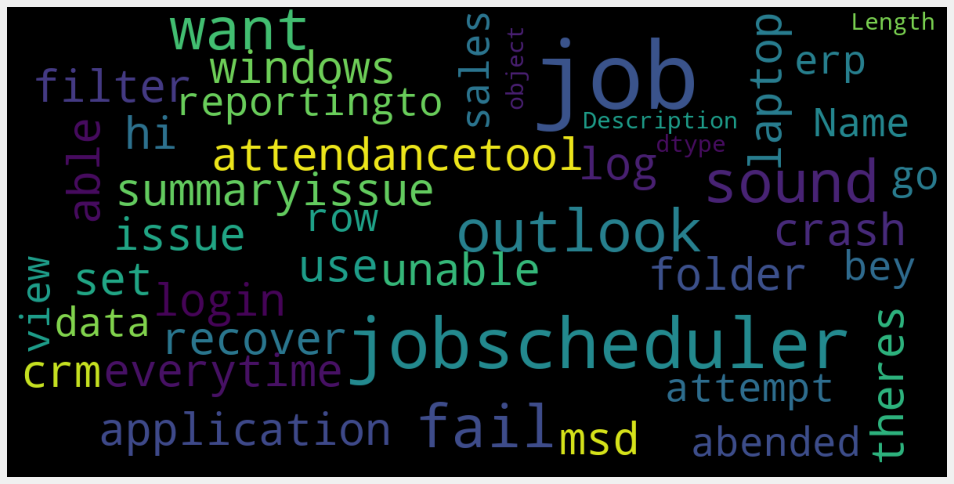

In [40]:
show_wordcloud(df.Description)

In [0]:
#Now let's convert all the words into a sentence by joing them for the short description and description
df['Short description'] = df['Short description'].map(lambda x: ' '.join(x))
df['Description'] = df['Description'].map(lambda x: ' '.join(x))

In [42]:
#Now let's plot frequency distribution of words
from nltk.probability import FreqDist
fdist = FreqDist()
text = df.Description.str.cat(sep=' ')
for word in word_tokenize(text):
    fdist[word.lower()] += 1
fdist.most_common(50)

#fdist.plot(50)



[('please', 14148),
 ('sep', 8175),
 ('event', 7802),
 ('need', 7000),
 ('job', 6905),
 ('user', 6282),
 ('access', 5919),
 ('via', 5909),
 ('id', 5682),
 ('ticket', 5663),
 ('report', 5638),
 ('email', 5540),
 ('system', 5524),
 ('erp', 5374),
 ('see', 5138),
 ('ip', 5037),
 ('work', 4882),
 ('help', 4673),
 ('issue', 4638),
 ('error', 4616),
 ('team', 4522),
 ('company', 4470),
 ('deny', 4435),
 ('use', 4404),
 ('src', 4382),
 ('dst', 4382),
 ('inside', 4360),
 ('asa', 4356),
 ('log', 4296),
 ('name', 4274),
 ('accessgroup', 4215),
 ('aclinside', 4215),
 ('im', 4173),
 ('source', 4161),
 ('receive', 4122),
 ('order', 4109),
 ('fail', 4051),
 ('udp', 4018),
 ('hostname', 3894),
 ('androidbaadea', 3870),
 ('ecff', 3870),
 ('relay', 3866),
 ('correlationdata', 3858),
 ('dhcpd', 3858),
 ('dhcpack', 3858),
 ('eth', 3858),
 ('leaseduration', 3858),
 ('try', 3853),
 ('noris', 3802),
 ('send', 3781)]

From the above frequesncy distribution we can see their are few words which are mostly repeated this will impact the learning curve.let's try to replace

In [0]:
df['Description'] = df['Description'].apply((lambda x: re.sub('please|hello|team|hi|pm|“','',x)))

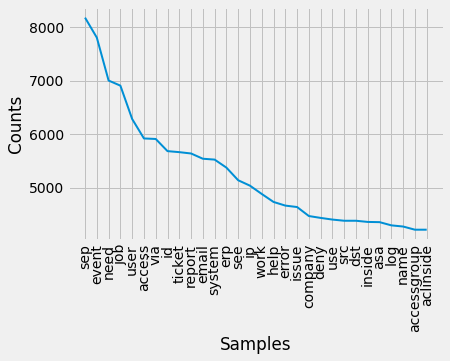

In [44]:
#Now let's plot the frequency distribution after cleaning the data
fdist = FreqDist()
text = df.Description.str.cat(sep=' ')
for word in word_tokenize(text):
    fdist[word.lower()] += 1

fdist.plot(30)


In [0]:
df['num_words'] = df.Description.apply(lambda x : len(x.split(" ")))
df['bins']=pd.cut(df.num_words, bins=[0,100,300,500,1000, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>1000'])

In [46]:
df.head()

,Short description,Description,Caller,Assignment group,target,num_words,bins
6096,able login attendancetool,able login attendancetool application user id,cgvhxjay znyuopqk,GRP_0,0,6,0-100
3334,sound issue,summaryissue sound laptop theres sound,kexcsbgw lzabjxwf,GRP_0,0,5,0-100
5962,outlook crash msd crm outlook issue,outlook crash msd crm outlook issue,wzbqmhdf gxsiadqw,GRP_0,0,6,0-100
187,recover folder mistake copy drive,want recover folder,pbtauqyx civyxdkl,GRP_0,0,3,0-100
7778,unable log windows,unable log windows,bfmlysrk olbthfqr,GRP_0,0,3,0-100


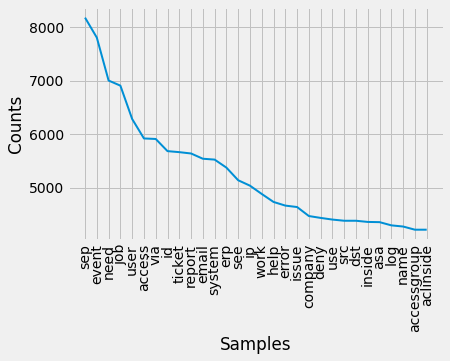

In [47]:
#Now let's plot the distribution after clean up of some words
fdist = FreqDist()
text = df.Description.str.cat(sep=' ')
for word in word_tokenize(text):
    fdist[word.lower()] += 1
fdist.plot(30)

In [48]:
from nltk.probability import FreqDist
fdist = FreqDist()
text = df['Short description'].str.cat(sep=' ')
for word in word_tokenize(text):
    fdist[word.lower()] += 1
fdist.most_common(100)

[('job', 6491),
 ('jobscheduler', 3720),
 ('fail', 3256),
 ('erp', 3195),
 ('need', 3168),
 ('access', 3145),
 ('work', 3072),
 ('report', 3056),
 ('please', 2925),
 ('unable', 2531),
 ('issue', 2165),
 ('email', 2125),
 ('reset', 1868),
 ('crm', 1749),
 ('error', 1682),
 ('password', 1590),
 ('hostname', 1586),
 ('system', 1449),
 ('change', 1409),
 ('»', 1388),
 ('space', 1339),
 ('plant', 1329),
 ('account', 1193),
 ('ticketno', 1192),
 ('update', 1136),
 ('company', 1119),
 ('since', 1118),
 ('usa', 1090),
 ('”', 1066),
 ('connection', 1038),
 ('user', 1037),
 ('file', 984),
 ('ticket', 975),
 ('receive', 968),
 ('respond', 939),
 ('expense', 935),
 ('security', 921),
 ('use', 911),
 ('complete', 895),
 ('outbound', 871),
 ('require', 836),
 ('able', 825),
 ('link', 816),
 ('order', 785),
 ('tool', 782),
 ('incidents', 774),
 ('repeat', 773),
 ('server', 768),
 ('telephonysoftware', 765),
 ('tcp', 764),
 ('last', 754),
 ('production', 752),
 ('ç', 752),
 ('forecast', 746),
 ('new',

In [0]:
df['Short description'] = df['Short description'].apply((lambda x: re.sub('please|erp|et|»|pm|”','',x)))

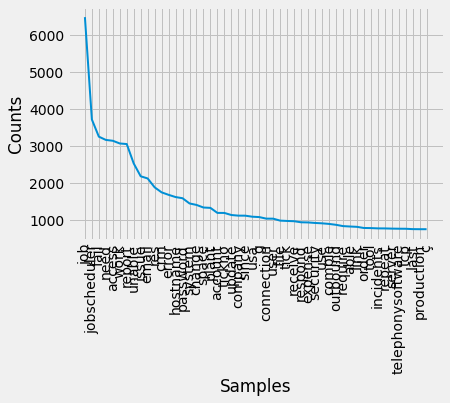

In [50]:
fdist = FreqDist()
text = df['Short description'].str.cat(sep=' ')
for word in word_tokenize(text):
    fdist[word.lower()] += 1
fdist.plot(50)

In [51]:
df.head()

,Short description,Description,Caller,Assignment group,target,num_words,bins
6096,able login attendancool,able login attendancetool application user id,cgvhxjay znyuopqk,GRP_0,0,6,0-100
3334,sound issue,summaryissue sound laptop theres sound,kexcsbgw lzabjxwf,GRP_0,0,5,0-100
5962,outlook crash msd crm outlook issue,outlook crash msd crm outlook issue,wzbqmhdf gxsiadqw,GRP_0,0,6,0-100
187,recover folder mistake copy drive,want recover folder,pbtauqyx civyxdkl,GRP_0,0,3,0-100
7778,unable log windows,unable log windows,bfmlysrk olbthfqr,GRP_0,0,3,0-100


In [0]:
# Concatenate the two columns i.e short description and description
df['Description'] = df['Short description'].str.cat(df['Description'], sep =" ")

In [53]:
df.head()

,Short description,Description,Caller,Assignment group,target,num_words,bins
6096,able login attendancool,able login attendancool able login attendancet...,cgvhxjay znyuopqk,GRP_0,0,6,0-100
3334,sound issue,sound issue summaryissue sound laptop theres s...,kexcsbgw lzabjxwf,GRP_0,0,5,0-100
5962,outlook crash msd crm outlook issue,outlook crash msd crm outlook issue outlook cr...,wzbqmhdf gxsiadqw,GRP_0,0,6,0-100
187,recover folder mistake copy drive,recover folder mistake copy drive want recover...,pbtauqyx civyxdkl,GRP_0,0,3,0-100
7778,unable log windows,unable log windows unable log windows,bfmlysrk olbthfqr,GRP_0,0,3,0-100


In [0]:
df_final = df.drop(['Short description','Caller','Assignment group','bins'], axis=1)

In [55]:
df_final.head()

,Description,target,num_words
6096,able login attendancool able login attendancet...,0,6
3334,sound issue summaryissue sound laptop theres s...,0,5
5962,outlook crash msd crm outlook issue outlook cr...,0,6
187,recover folder mistake copy drive want recover...,0,3
7778,unable log windows unable log windows,0,3


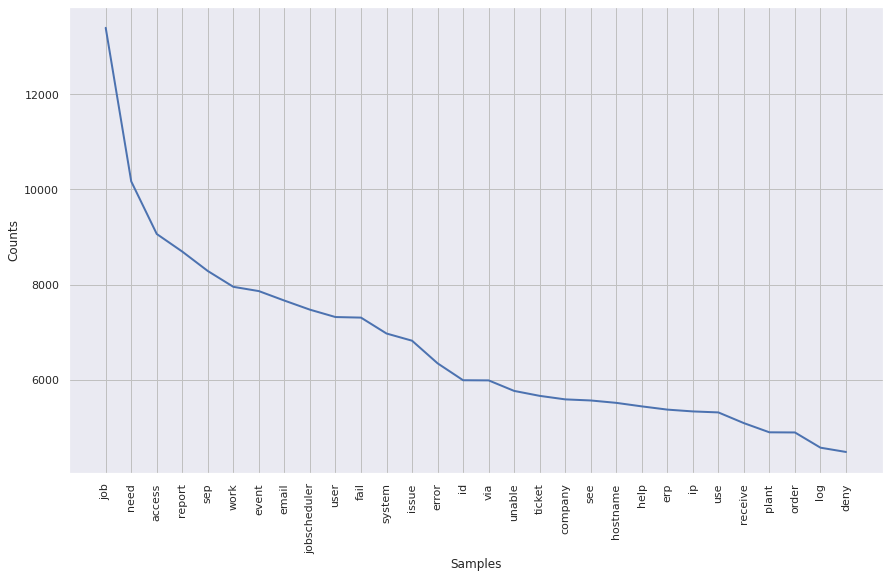

In [62]:
text = df_final['Description'].str.cat(sep=' ')
tokens = word_tokenize(text)
fdist = FreqDist(tokens)
fdist.plot(30)

#### **Visualizing different text features :**

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
import re
cv=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
X=cv.fit_transform(df_final['Description'])

In [58]:
list(cv.vocabulary_.keys())[:10]

['able',
 'login',
 'application',
 'user',
 'id',
 'able login',
 'user id',
 'issue',
 'laptop',
 'outlook']

[Text(0, 0, 'job'),
 Text(0, 0, 'need'),
 Text(0, 0, 'access'),
 Text(0, 0, 'report'),
 Text(0, 0, 'sep'),
 Text(0, 0, 'work'),
 Text(0, 0, 'event'),
 Text(0, 0, 'email'),
 Text(0, 0, 'jobscheduler'),
 Text(0, 0, 'user'),
 Text(0, 0, 'fail'),
 Text(0, 0, 'system'),
 Text(0, 0, 'issue'),
 Text(0, 0, 'error'),
 Text(0, 0, 'id'),
 Text(0, 0, 'via'),
 Text(0, 0, 'unable'),
 Text(0, 0, 'ticket'),
 Text(0, 0, 'company'),
 Text(0, 0, 'see')]

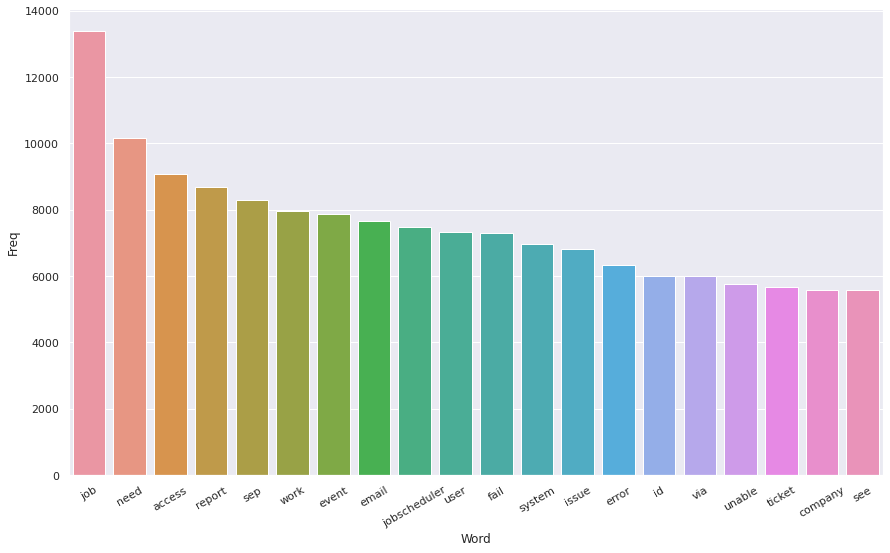

In [59]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(df_final['Description'], n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

                  Bi-gram  Freq
0       fail jobscheduler  6179
1                asa deny  4219
2              src inside  4215
3              inside dst  4215
4   accessgroup aclinside  4215
5           dhcpd dhcpack  3858
6                 via eth  3858
7               eth relay  3858
8     relay leaseduration  3858
9               dst noris  3802
10      noris accessgroup  3802
11       jobscheduler job  3699
12                sep asa  3600
13    leaseduration renew  3498
14    correlationdata sep  3492
15              sep dhcpd  3492
16               deny udp  3472
17                udp src  3472
18         aclinside xeda  3440
19   xeda correlationdata  3440


[Text(0, 0, 'fail jobscheduler'),
 Text(0, 0, 'asa deny'),
 Text(0, 0, 'src inside'),
 Text(0, 0, 'inside dst'),
 Text(0, 0, 'accessgroup aclinside'),
 Text(0, 0, 'dhcpd dhcpack'),
 Text(0, 0, 'via eth'),
 Text(0, 0, 'eth relay'),
 Text(0, 0, 'relay leaseduration'),
 Text(0, 0, 'dst noris'),
 Text(0, 0, 'noris accessgroup'),
 Text(0, 0, 'jobscheduler job'),
 Text(0, 0, 'sep asa'),
 Text(0, 0, 'leaseduration renew'),
 Text(0, 0, 'correlationdata sep'),
 Text(0, 0, 'sep dhcpd'),
 Text(0, 0, 'deny udp'),
 Text(0, 0, 'udp src'),
 Text(0, 0, 'aclinside xeda'),
 Text(0, 0, 'xeda correlationdata')]

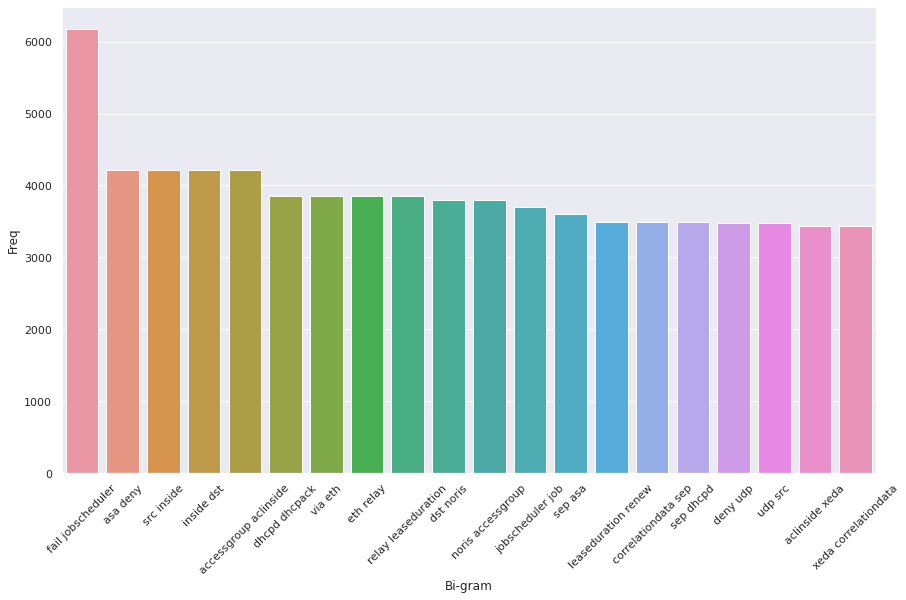

In [60]:

#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(df_final['Description'], n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)

                          Tri-gram  Freq
0                   src inside dst  4215
1                    via eth relay  3858
2          eth relay leaseduration  3858
3                 inside dst noris  3802
4            dst noris accessgroup  3802
5      noris accessgroup aclinside  3802
6                     sep asa deny  3572
7        relay leaseduration renew  3498
8        correlationdata sep dhcpd  3492
9                sep dhcpd dhcpack  3492
10                    asa deny udp  3472
11                    deny udp src  3472
12                  udp src inside  3472
13      accessgroup aclinside xeda  3440
14  aclinside xeda correlationdata  3440
15        xeda correlationdata sep  3440
16              dhcpd dhcpack ecff  3440
17      dhcpack ecff androidbaadea  3440
18          ecff androidbaadea via  3440
19           androidbaadea via eth  3440


[Text(0, 0, 'src inside dst'),
 Text(0, 0, 'via eth relay'),
 Text(0, 0, 'eth relay leaseduration'),
 Text(0, 0, 'inside dst noris'),
 Text(0, 0, 'dst noris accessgroup'),
 Text(0, 0, 'noris accessgroup aclinside'),
 Text(0, 0, 'sep asa deny'),
 Text(0, 0, 'relay leaseduration renew'),
 Text(0, 0, 'correlationdata sep dhcpd'),
 Text(0, 0, 'sep dhcpd dhcpack'),
 Text(0, 0, 'asa deny udp'),
 Text(0, 0, 'deny udp src'),
 Text(0, 0, 'udp src inside'),
 Text(0, 0, 'accessgroup aclinside xeda'),
 Text(0, 0, 'aclinside xeda correlationdata'),
 Text(0, 0, 'xeda correlationdata sep'),
 Text(0, 0, 'dhcpd dhcpack ecff'),
 Text(0, 0, 'dhcpack ecff androidbaadea'),
 Text(0, 0, 'ecff androidbaadea via'),
 Text(0, 0, 'androidbaadea via eth')]

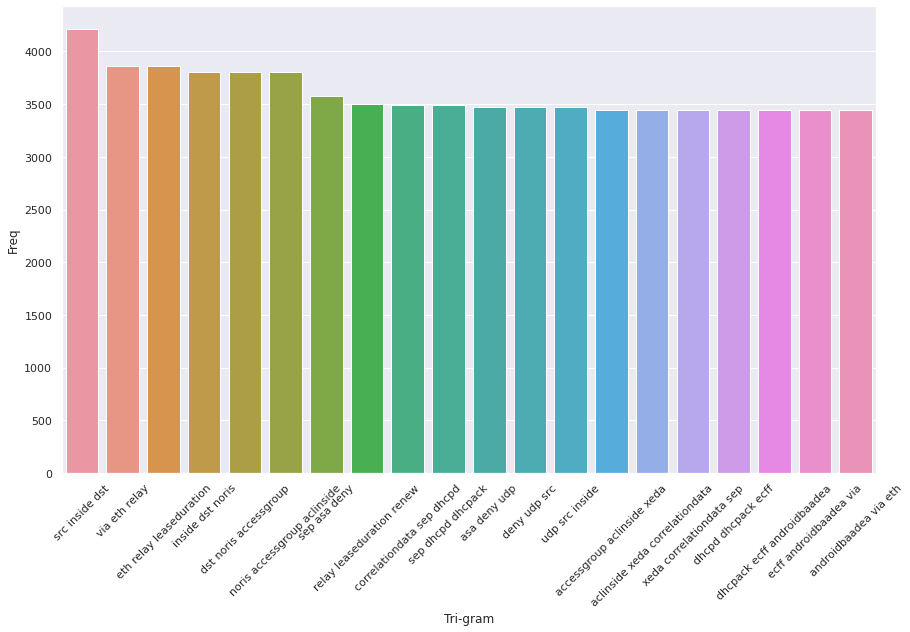

In [61]:
#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top3_words = get_top_n3_words(df_final['Description'], n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
print(top3_df)
#Barplot of most freq Tri-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(x="Tri-gram", y="Freq", data=top3_df)
j.set_xticklabels(j.get_xticklabels(), rotation=45)

**Training and Validation data split**

In [63]:
df_final.describe()

,target,num_words
count,48914.000000,48914.000000
mean,36.500000,23.568753
std,21.360228,49.057885
min,0.000000,1.000000
25%,18.000000,6.000000
50%,36.500000,13.000000
75%,55.000000,25.000000
max,73.000000,747.000000


In [0]:
MAX_SEQUENCE_LENGTH = 700
MAX_NB_WORDS = 12000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2

In [65]:
sentences = df_final['Description'].values
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, split=' ')
tokenizer.fit_on_texts(sentences) #.values)
sequence = tokenizer.texts_to_sequences(sentences) #df_cleaned_text['full_description'].values)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 12860


In [66]:
X = tokenizer.texts_to_sequences(df_final['Description'])
X = pad_sequences(X, maxlen = MAX_SEQUENCE_LENGTH)
y = pd.get_dummies(df_final['target']).values

print('Shape of data:', X.shape)
print('Shape of label:', y.shape)

Shape of data: (48914, 700)
Shape of label: (48914, 74)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

**Importing the Glove embedding for the word embedding**

In [0]:
glove_file = "/content/drive/My Drive/Capstone project/glove.6B.zip"
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

In [69]:
embeddings_index = {}
f = open('/content/glove.6B.200d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 200d.' % len(embeddings_index))

Total 400001 word vectors in Glove 6B 200d.


In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

tokens = []
labels = []

for word,i in word_index.items():
    temp = embeddings_index.get(word)
    if temp is not None:
        embedding_matrix[i] = temp
        
#for plotting
        tokens.append(embedding_matrix[i])
        labels.append(word)

(200, 2)


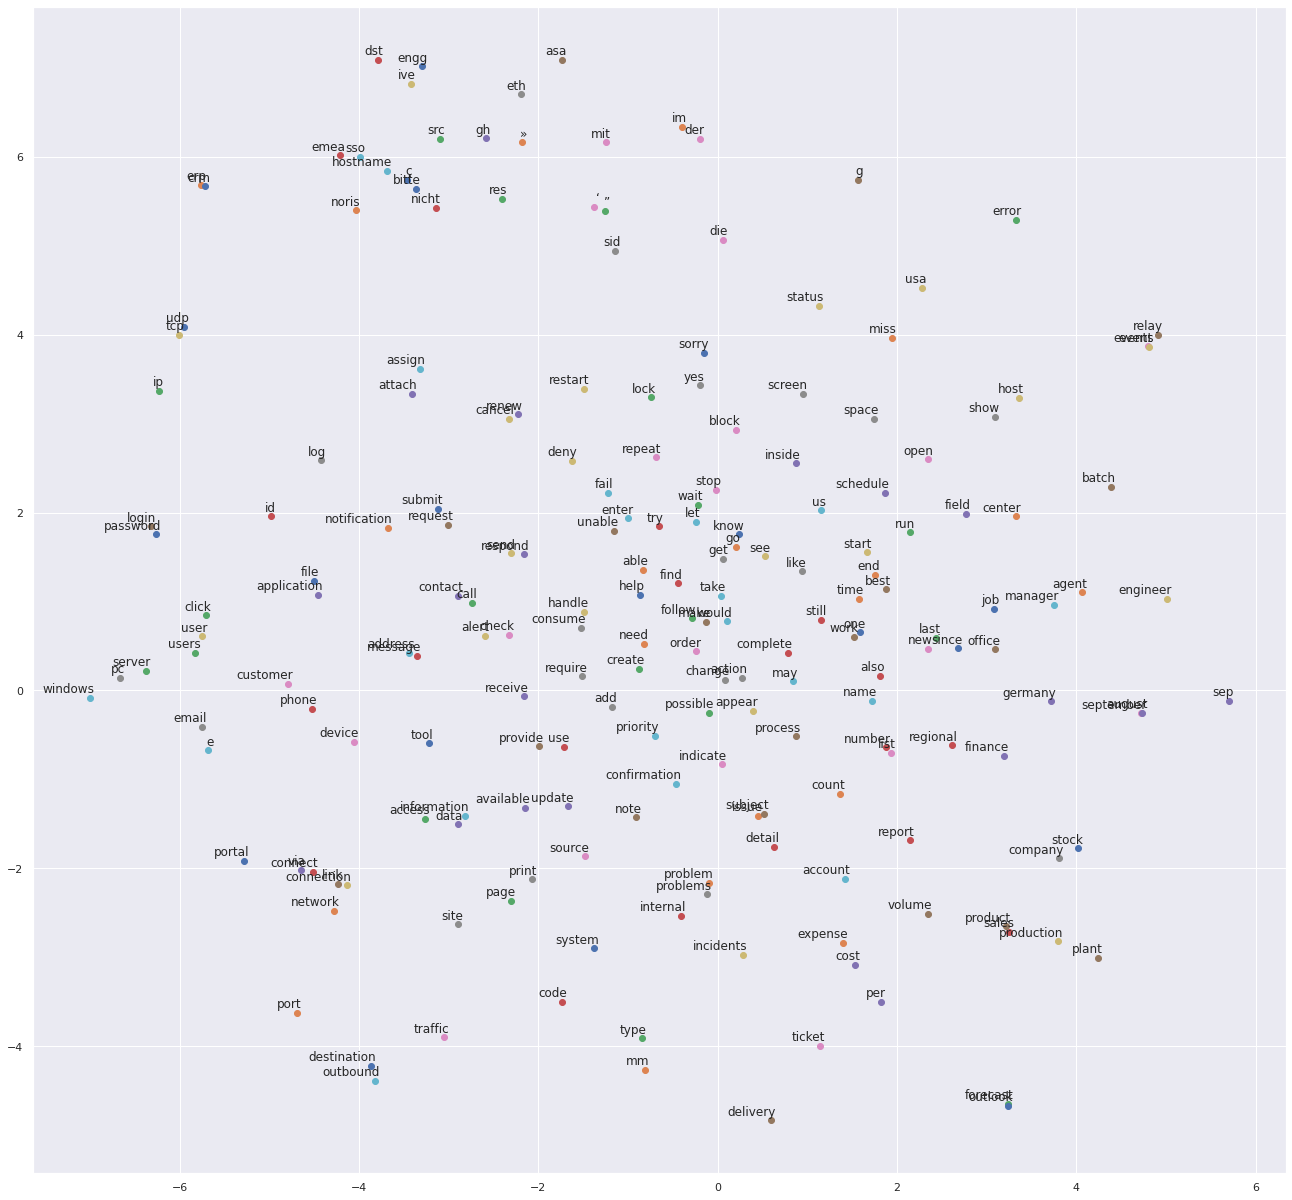

In [71]:
#TSNE algorithm used to visualize word embeddings having huge amount (100) dimensions

def tsne():
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens[:200])
    print(new_values.shape)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20,20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

    
    
    
    
tsne()

**Model Building using neural networks**

In [0]:
from keras.callbacks import ModelCheckpoint
#from tensorflow.keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Embedding,Bidirectional,Dense,Flatten,LSTM,GlobalMaxPooling1D,Dropout,SpatialDropout1D

In [79]:
model = Sequential()
model.add(Embedding(len(word_index) + 1 , EMBEDDING_DIM , input_length = MAX_SEQUENCE_LENGTH, weights = [embedding_matrix]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences = True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(64,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(74, activation='softmax'))

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 700, 200)          2572200   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 700, 200)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 700, 256)          336896    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 74)               

In [0]:
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
#add = Adam(lr = 0.01)
#setting learing rate for adam optimizer
optadm = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False,epsilon=1e-08)
#setting early stopping
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=1, verbose=1, mode='auto',baseline=None, restore_best_weights=False)

cp=ModelCheckpoint('model.hdf5',monitor='val_accuracy',verbose=1,save_best_only=True)
model.compile(loss = 'categorical_crossentropy' , optimizer = optadm , metrics = ['accuracy'])

In [0]:
_batchsize=500
_epochs=5

In [84]:
model.fit(X_train,y_train,epochs = _epochs, batch_size = _batchsize, validation_data = (X_test,y_test),callbacks=[cp,es])

Train on 36685 samples, validate on 12229 samples
Epoch 1/5
36685/36685 [==============================] - 326s 9ms/step - loss: 3.5212 - accuracy: 0.2273 - val_loss: 2.0629 - val_accuracy: 0.5698

Epoch 00001: val_accuracy improved from -inf to 0.56979, saving model to model.hdf5
Epoch 2/5
36685/36685 [==============================] - 331s 9ms/step - loss: 1.7896 - accuracy: 0.5606 - val_loss: 0.9754 - val_accuracy: 0.7639

Epoch 00002: val_accuracy improved from 0.56979 to 0.76392, saving model to model.hdf5
Epoch 3/5
36685/36685 [==============================] - 330s 9ms/step - loss: 1.0558 - accuracy: 0.7205 - val_loss: 0.6118 - val_accuracy: 0.8424

Epoch 00003: val_accuracy improved from 0.76392 to 0.84242, saving model to model.hdf5
Epoch 4/5
36685/36685 [==============================] - 328s 9ms/step - loss: 0.7314 - accuracy: 0.8058 - val_loss: 0.4294 - val_accuracy: 0.8831

Epoch 00004: val_accuracy improved from 0.84242 to 0.88306, saving model to model.hdf5
Epoch 5/5
366

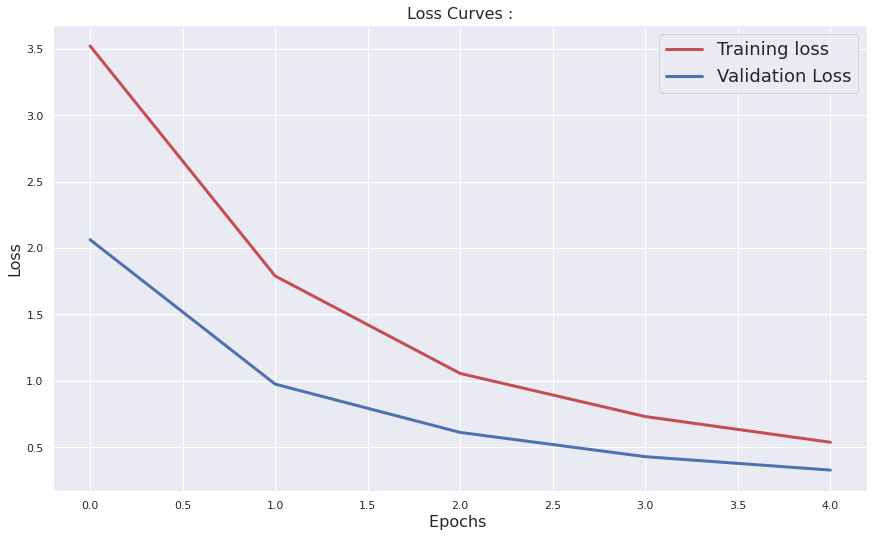

In [88]:
fig1 = plt.figure()
plt.plot(model.history.history['loss'],'r',linewidth=3.0)
plt.plot(model.history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :',fontsize=16)
fig1.savefig('loss.png')
plt.show()

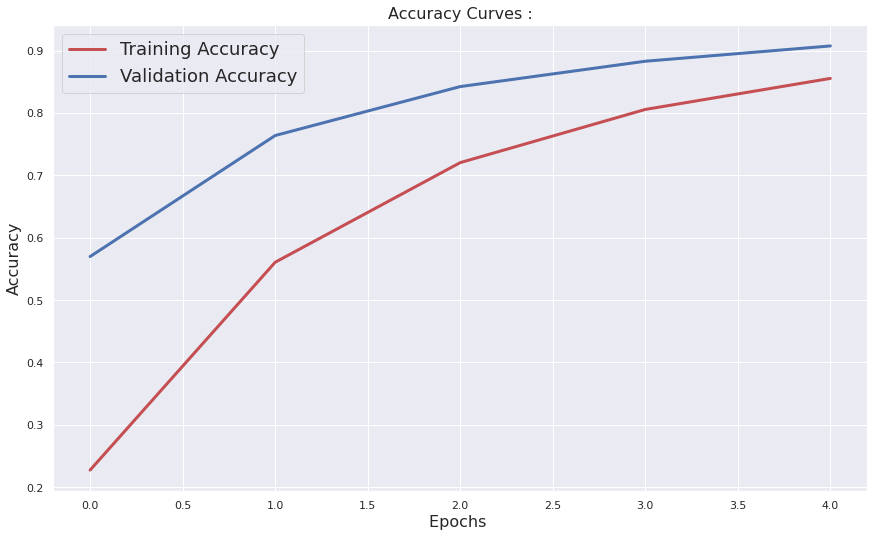

In [89]:
fig2=plt.figure()
plt.plot(model.history.history['accuracy'],'r',linewidth=3.0)
plt.plot(model.history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves :',fontsize=16)
fig2.savefig('accuracy.png')
plt.show()

In [90]:
score , acc = model.evaluate(X_test,y_test,batch_size = 500 , verbose = 2)
print("Test Accuracy : " ,acc)

Test Accuracy :  0.9075967073440552


In [0]:
predicted = model.predict(X_test)

In [100]:
predicted[1]

array([1.0217679e-04, 2.8313920e-05, 6.9063085e-06, 5.2377031e-06,
       6.5396725e-06, 5.0934709e-06, 1.0352336e-08, 2.0908756e-07,
       3.8496373e-04, 1.6505126e-09, 1.1205647e-06, 2.9456141e-05,
       1.7179578e-04, 4.7974089e-07, 5.9134425e-05, 4.9880377e-06,
       2.9594506e-07, 6.9106960e-08, 6.6587868e-06, 2.3215972e-07,
       7.0551306e-07, 1.6434889e-05, 1.2253071e-07, 1.0699420e-04,
       1.1795548e-09, 2.7410211e-08, 6.6564274e-09, 7.4423297e-05,
       3.8670155e-06, 2.2067753e-07, 1.6550325e-10, 6.1569795e-06,
       1.5525760e-07, 4.7036160e-06, 1.1042441e-05, 9.0486839e-07,
       2.9305102e-06, 2.2190302e-07, 1.4944267e-07, 2.1544400e-04,
       4.2306949e-09, 1.5368347e-08, 1.3193811e-06, 6.2784471e-09,
       5.8003684e-06, 1.0843655e-04, 1.9088326e-05, 2.4500428e-09,
       9.9829203e-01, 8.0863405e-09, 1.1746373e-10, 1.4846265e-09,
       3.8841428e-08, 3.8778398e-06, 2.0658589e-10, 1.0965423e-09,
       9.0296631e-08, 1.6616639e-08, 7.5036539e-11, 1.2860735e

In [121]:
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
true_labels = np.argmax(y_test, axis=1)

print(metrics.confusion_matrix(true_labels, predicted))

24

In [0]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(true_labels, predicted))

In [0]:
from sklearn.preprocessing import LabelEncoder
import itertools

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [0]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(df_final.target.values)
text_labels = encoder.classes_ 
cnf_matrix = confusion_matrix(true_labels, predicted)
plt.figure(figsize=(100,100))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()